## Bibliotecas

In [7]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import distance_matrix
from adjustText import adjust_text
from matplotlib.patches import Polygon
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d, delaunay_plot_2d

## Datos

In [8]:
# Ruta al archivo
file_path = "../data/Towns_HB_2024-08-14.xlsx"

# Leer todas las hojas como un diccionario {nombre_hoja: DataFrame}
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Filtrar solo las hojas que tienen datos (al menos una fila no vacía)
non_empty_sheets = {name: df for name, df in all_sheets.items() if not df.dropna(how='all').empty}

# Mostrar nombres de hojas con datos
print(f"Hojas con datos: {list(non_empty_sheets.keys())}")

Hojas con datos: ['Towns', 'Triple Alliance towns', 'Tenochtitlan', 'Zempoala', '79 Destinations', 'Tecpilpan']


In [9]:
df_towns = non_empty_sheets["Towns"]
df_triple_alliance = non_empty_sheets["Triple Alliance towns"]
df_tenochtitlan = non_empty_sheets["Tenochtitlan"]
df_zempoala = non_empty_sheets["Zempoala"]
df_79 = non_empty_sheets["79 Destinations"]
df_tecpilpan = non_empty_sheets["Tecpilpan"]

### Definir coordenadas y pueblos

In [10]:
coords = df_towns[["Longitude", "Latitude"]].values
names = df_towns["Toponym"].values

## Calcular el diagrama de Voronoi

<Figure size 1000x1000 with 0 Axes>

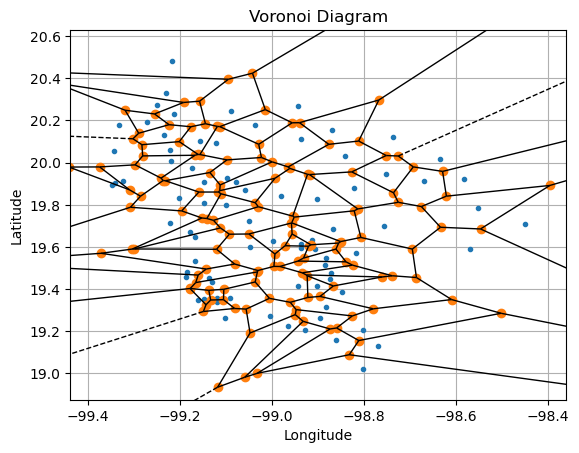

In [11]:
# Calcular el diagrama de Voronoi
vor = Voronoi(coords)

# === Graficar diagrama de Voronoi ===
plt.figure(figsize=(10, 10))
voronoi_plot_2d(vor, show_vertices=True, show_points=True)
plt.title("Voronoi Diagram")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

## Calcular la triangulación de Delanay

<Figure size 1000x1000 with 0 Axes>

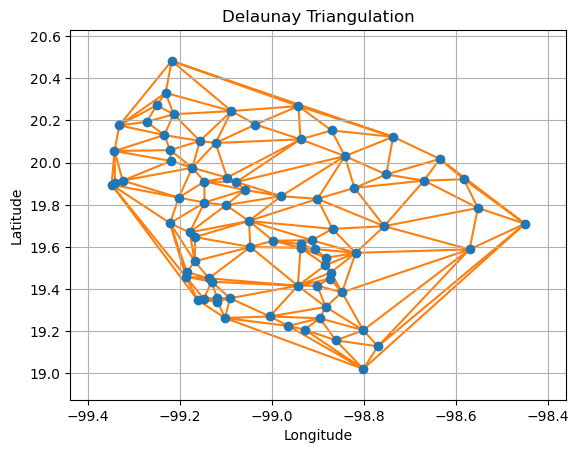

In [18]:
# Calcular la triangulación de Delaunay
delaunay = Delaunay(coords)

# === Graficar triangulación de Delaunay ===
plt.figure(figsize=(10, 10))
delaunay_plot_2d(delaunay)
plt.title("Delaunay Triangulation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [14]:
import numpy as np
from scipy.spatial import Delaunay, distance_matrix
import networkx as nx

def compute_rng_from_delaunay(coords):
    """
    Compute the Relative Neighborhood Graph (RNG) from a set of 2D coordinates
    using Algorithm (2) based on the Delaunay triangulation.

    Parameters:
        coords (np.ndarray): Array of shape (n, 2) with coordinates.

    Returns:
        G (nx.Graph): Undirected graph representing the RNG.
    """
    n = coords.shape[0]
    dist_matrix = distance_matrix(coords, coords)
    
    # Delaunay triangulation
    tri = Delaunay(coords)

    # Build Delaunay graph (undirected edges from simplices)
    delaunay_edges = set()
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                a, b = sorted((simplex[i], simplex[j]))
                delaunay_edges.add((a, b))

    rng_edges = set()
    
    for i, j in delaunay_edges:
        # Find the shared neighbors of i and j in the Delaunay triangulation
        neighbors_i = set(np.where(dist_matrix[i] < np.inf)[0])
        neighbors_j = set(np.where(dist_matrix[j] < np.inf)[0])
        common_neighbors = neighbors_i & neighbors_j - {i, j}

        # According to the algorithm, we check up to two pk
        pk_list = [k for k in tri.vertex_neighbor_vertices[1][
            tri.vertex_neighbor_vertices[0][i]:tri.vertex_neighbor_vertices[0][i+1]] if k != j]
        pk_list += [k for k in tri.vertex_neighbor_vertices[1][
            tri.vertex_neighbor_vertices[0][j]:tri.vertex_neighbor_vertices[0][j+1]] if k != i]
        pk_list = list(set(pk_list))

        # Compute d^k_max = max(d(i, k), d(j, k)) for each k
        max_dk = np.inf
        if pk_list:
            max_dk = min([max(dist_matrix[i, k], dist_matrix[j, k]) for k in pk_list])

        if dist_matrix[i, j] <= max_dk:
            rng_edges.add((i, j))

    # Build graph
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(rng_edges)
    
    return G


In [19]:
import matplotlib.pyplot as plt
import networkx as nx
from adjustText import adjust_text

def plot_rng_graph(coords, names, rng_graph):
    """
    Plot the Relative Neighborhood Graph with labeled nodes using adjustText.
    
    Parameters:
        coords (np.ndarray): Array of shape (n, 2) with [lon, lat].
        names (list): List of labels (e.g., toponyms).
        rng_graph (nx.Graph): Graph object representing the RNG.
    """
    # Assign positions and labels to nodes
    for i, (x, y) in enumerate(coords):
        rng_graph.nodes[i]['pos'] = (x, y)
        rng_graph.nodes[i]['label'] = names[i]

    pos = nx.get_node_attributes(rng_graph, 'pos')
    labels = nx.get_node_attributes(rng_graph, 'label')

    plt.figure(figsize=(12, 12))
    nx.draw(
        rng_graph,
        pos,
        node_color='skyblue',
        with_labels=False,
        node_size=100,
        edge_color='black'
    )

    texts = []
    for i, (x, y) in pos.items():
        texts.append(plt.text(x, y, labels[i], fontsize=8))

    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5, shrinkA=5),
        expand_points=(1.2, 1.2),
        force_text=0.5,
        force_points=0.2
    )

    plt.title("Relative Neighborhood Graph (RNG)")
    plt.axis("equal")
    plt.grid(True)
    plt.show()


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


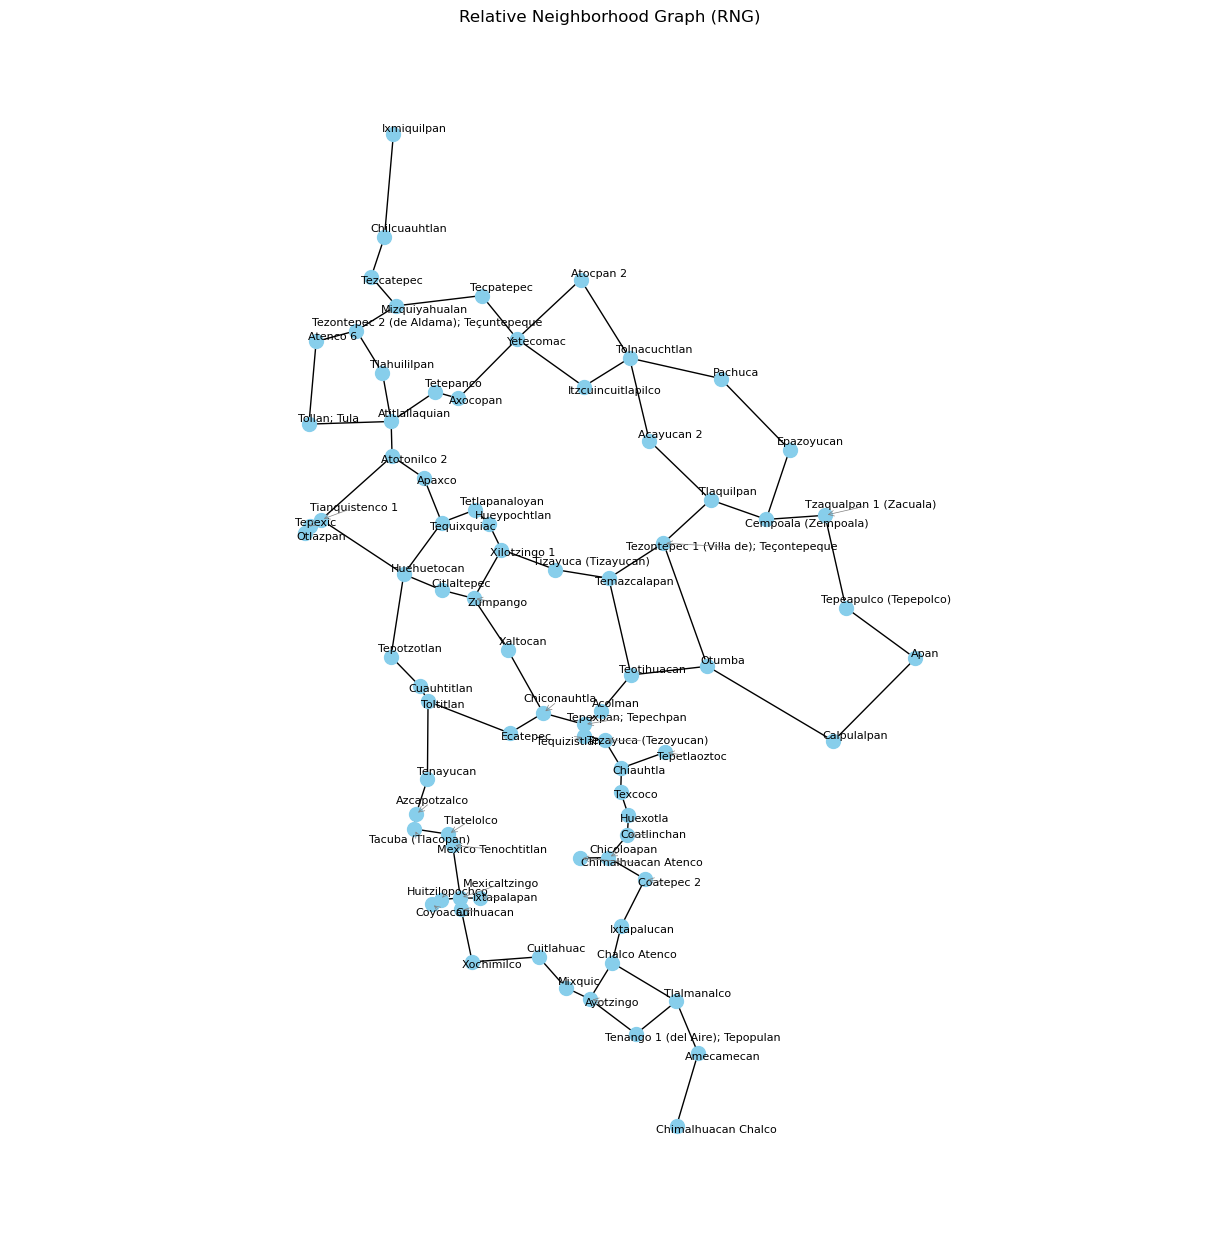

In [20]:
# Assuming you already have:
# coords = df_towns[["Longitude", "Latitude"]].values
# names = df_towns["Toponym"].values

rng_graph = compute_rng_from_delaunay(coords)
plot_rng_graph(coords, names, rng_graph)


In [22]:
import numpy as np

def rng_adjacency_matrix(rng_graph, n_nodes):
    """
    Construct a symmetric adjacency matrix from a NetworkX RNG graph.

    Parameters:
        rng_graph (nx.Graph): Graph output from compute_rng_from_delaunay().
        n_nodes (int): Total number of nodes (same order as input coords).

    Returns:
        adj_matrix (np.ndarray): (n x n) symmetric adjacency matrix with 0/1 entries.
    """
    adj_matrix = np.zeros((n_nodes, n_nodes), dtype=int)

    for i, j in rng_graph.edges():
        adj_matrix[i, j] = 1
        adj_matrix[j, i] = 1  # Symmetric

    return adj_matrix


In [33]:
# 1. Compute the graph from coords
rng_graph = compute_rng_from_delaunay(coords)

# 2. Get adjacency matrix
adj_rng = rng_adjacency_matrix(rng_graph, len(coords))

# # 3. Optional: save to CSV
# import pandas as pd
# pd.DataFrame(adj_rng, index=names, columns=names).to_csv("adj_rng.csv")

adj_rng.shape

(80, 80)

In [32]:
# Load the beta skeleton adjacency matrix from CSV
df_beta_loaded = pd.read_csv("../data/adj_beta_skeleton.csv")

# Convert to NumPy array (if needed for comparison)
adj_beta_loaded = df_beta_loaded.values

adj_beta_loaded.shape

(80, 80)

In [34]:
# import numpy as np

# # Load beta skeleton adjacency matrix
# df_beta_loaded = pd.read_csv("../data/adj_beta_skeleton.csv")  # Use index_col=0 to skip label column
# adj_beta_loaded = df_beta_loaded.values.astype(int)

# # Generate RNG adjacency matrix
# rng_graph = compute_rng_from_delaunay(coords)
# adj_rng = rng_adjacency_matrix(rng_graph, len(coords))

# === 1. Difference matrix ===
diff_matrix = adj_rng - adj_beta_loaded

# === 2. Count differences ===
n_different = np.sum(diff_matrix != 0)
print(f"Total differences between RNG and beta skeleton: {n_different}")

# === 3. Where they differ ===
rows, cols = np.where(diff_matrix != 0)
diff_edges = list(zip(rows, cols))
print("Differing edges (i, j):")
for i, j in diff_edges:
    print(f"{names[i]} ↔ {names[j]} (RNG: {adj_rng[i,j]}, Beta: {adj_beta_loaded[i,j]})")


Total differences between RNG and beta skeleton: 0
Differing edges (i, j):


In [27]:
adj_rng.shape

(80, 80)

In [30]:
adj_beta_loaded.shape

(80, 80)